# Polyp Segementation using U-Net

## Imports

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

## Data Preparation

### Data Download

Install kaggle

In [1]:
# !pip install kaggle

Set up to download kaggle datasets

In [2]:
# %%bash
# mkdir ~/.kaggle
# cp kaggle.json ~/.kaggle/
# chmod 600 ~/.kaggle/kaggle.json

Download the data from Kaggle

In [3]:
# !kaggle datasets download -d balraj98/cvcclinicdb

Unzip the dataset and store it in the drive

In [4]:
# !unzip /content/cvcclinicdb.zip -d /content/drive/MyDrive/image_segmentation/cvcclinic_data/

### Load Images and Masks

In [44]:
DATASET_PATH: str = "/content/drive/MyDrive/image_segmentation/cvcclinic_data/"
ORIGINAL_IMAGES: str = os.path.join(DATASET_PATH, "PNG/Original")
MASK_IMAGES: str = os.path.join(DATASET_PATH, "PNG/Ground Truth")

# Hyperparameters
BATCH: int = 8
lr: float = 1e-4
EPOCHS: int = 20

In [7]:
def load_data(split: int = 0.1):

    images = sorted(glob(ORIGINAL_IMAGES + "/*.png"))
    masks = sorted(glob(MASK_IMAGES + "/*.png"))

    total_size: int = len(images)
    valid_size: int = int(split * total_size)
    test_size: int = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def read_image(path):
    path = path.decode()

    img = cv2.imread(path, cv2.IMREAD_COLOR)

    # resize the image
    img = cv2.resize(img, (256, 256))

    # normalize
    img = img / 255.0
    return img

def read_mask(path):
    path = path.decode()

    mask_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # resize the image
    mask_img = cv2.resize(mask_img, (256, 256))

    # normalize
    mask_img = mask_img / 255.0

    mask_img = np.expand_dims(mask_img, axis=-1)
    
    return mask_img


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])

    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])

    return x, y


# to create tensorflow dataset
def tf_dataset(x, y, batch: int = 8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [38]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

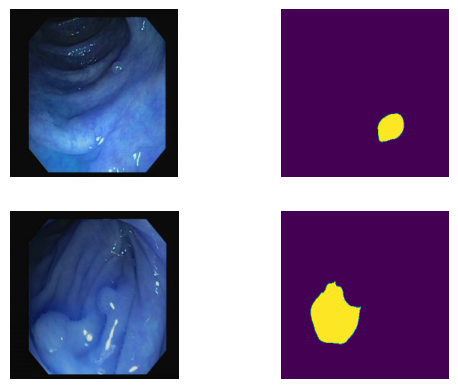

In [39]:
for image_batch, mask_batch in train_dataset.take(1):
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        if i % 2 == 0: 
            plt.imshow(image_batch[i])
        else:
            plt.imshow(mask_batch[i])
        plt.axis("off")

## Model

In [8]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def build_model():
    size: int = 256
    num_filters: list[int] = [16, 32, 48, 64]

    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs

    # Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    # Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    # Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)
    
    # output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [ ]:
model = build_model()

model.summary()

## Train

In [10]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [13]:
# optimizer
opt = tf.keras.optimizers.Adam(lr)

# metrices
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]

# compile the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

# callbacks
callbacks = [
    ModelCheckpoint("files/model.h5"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
    CSVLogger("files/data.csv"),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]


train_steps = len(train_x) // BATCH
valid_steps = len(valid_x) // BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1

if len(valid_x) % BATCH != 0:
    valid_steps += 1

In [14]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/20
62/62 [==============================] - 162s 2s/step - loss: 0.5464 - acc: 0.7548 - recall: 0.3732 - precision: 0.1630 - iou: 0.0958 - val_loss: 0.6908 - val_acc: 0.5700 - val_recall: 0.7331 - val_precision: 0.1372 - val_iou: 0.0773 - lr: 1.0000e-04
Epoch 2/20
62/62 [==============================] - 8s 125ms/step - loss: 0.3674 - acc: 0.8897 - recall: 0.1980 - precision: 0.3648 - iou: 0.1081 - val_loss: 0.4384 - val_acc: 0.9058 - val_recall: 1.9700e-04 - val_precision: 0.0026 - val_iou: 0.0636 - lr: 1.0000e-04
Epoch 3/20
62/62 [==============================] - 8s 133ms/step - loss: 0.3111 - acc: 0.9121 - recall: 0.3986 - precision: 0.5640 - iou: 0.1379 - val_loss: 0.3467 - val_acc: 0.9085 - val_recall: 1.9700e-04 - val_precision: 0.0044 - val_iou: 0.0553 - lr: 1.0000e-04
Epoch 4/20
62/62 [==============================] - 7s 115ms/step - loss: 0.2771 - acc: 0.9233 - recall: 0.5129 - precision: 0.6287 - iou: 0.1673 - val_loss: 0.3154 - val_acc: 0.9116 - val_recall: 0.0000e

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

iou = history.history['iou']
val_iou = history.history['val_iou']
recall = history.history['recall']
val_recall = history.history['val_recall']
precision = history.history['precision']
val_precision = history.history['val_precision']

In [ ]:
def train_val_plot(acc, val_acc, loss, val_loss, iou, val_iou, recall, val_recall, precision, val_precision):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Model's Metrics Visualization")

    # Plot accuracy
    axs[0, 0].plot(range(1, len(acc) + 1), acc)
    axs[0, 0].plot(range(1, len(val_acc) + 1), val_acc)
    axs[0, 0].set_title('History of Accuracy')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend(['Training', 'Validation'])

    # Plot loss
    axs[0, 1].plot(range(1, len(loss) + 1), loss)
    axs[0, 1].plot(range(1, len(val_loss) + 1), val_loss)
    axs[0, 1].set_title('History of Loss')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(['Training', 'Validation'])

    # Plot IOU
    axs[1, 0].plot(range(1, len(iou) + 1), iou)
    axs[1, 0].plot(range(1, len(val_iou) + 1), val_iou)
    axs[1, 0].set_title('History of IOU')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('IOU')
    axs[1, 0].legend(['Training', 'Validation'])

    # Plot recall and precision
    axs[1, 1].plot(range(1, len(recall) + 1), recall)
    axs[1, 1].plot(range(1, len(val_recall) + 1), val_recall)
    axs[1, 1].plot(range(1, len(precision) + 1), precision)
    axs[1, 1].plot(range(1, len(val_precision) + 1), val_precision)
    axs[1, 1].set_title('History of Recall and Precision')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Score')
    axs[1, 1].legend(['Training Recall', 'Validation Recall', 'Training Precision', 'Validation Precision'])

    plt.tight_layout()
    plt.show()


train_val_plot(acc, val_acc, loss, val_loss, iou, val_iou, recall, val_recall, precision, val_precision)

## Evaluate the model

In [48]:
test_dataset = tf_dataset(test_x, test_y, batch=1)
test_steps = len(test_x) // 1

if len(test_x) % 1 != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

61/61 [==============================] - 1s 21ms/step - loss: 0.1653 - acc: 0.9505 - recall: 0.6385 - precision: 0.8302 - iou: 0.2967


[0.16530346870422363,
 0.9505492448806763,
 0.6385287642478943,
 0.8302450776100159,
 0.29672861099243164]

## Predict

In [32]:
def pred_read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    return x

def pred_read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

def pred_mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
for i, (x, y) in enumerate(zip(test_x, test_y)):
    x = pred_read_image(x)
    
    y = pred_read_mask(y)

    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5

    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3)) * 255.0

    all_images = [
        x * 255.0, white_line,
        pred_mask_parse(y), white_line,
        pred_mask_parse(y_pred) * 255.0
    ]
    image = np.concatenate(all_images, axis=1)

    cv2.imwrite(f"results/{i}.png", image)

## Creating zip file of the results

In [35]:
import shutil

# Specify the folder path you want to download
folder_path = '/content/results/'

# Specify the destination zip file path
zip_file_path = '/content/results.zip'

# Create a zip file of the folder
shutil.make_archive(zip_file_path, 'zip', folder_path)

'/content/results.zip.zip'